In [ ]:
import pandas as pd
import csv
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import gc
import sys
import os
 
os.system("pip install pytorch-nlp")
os.system("pip install pytorch_pretrained_bert")
import random as rn
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn

In [ ]:
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')


home_dir = "/content/gdrive/MyDrive/Colab Notebooks/COMP_551Assignment2/"

Mounted at /content/gdrive


In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

#Data Processing 

In [ ]:
'''load data'''
data_dir = home_dir + "aclImdb/train/labeledBow.feat"
X,Y = load_svmlight_file(data_dir, multilabel = False, zero_based = True)
# print(X[:,1]) # :,n -> nth feature in all reviews

# print(type(X))
'''group by features and get occurences'''
ind = X.indices
ind_series = pd.Series(ind, name='index')
ind_gp = ind_series.groupby(lambda x: ind_series[x])
ind_gp_df = ind_gp.count().to_frame(name='occurence')
ind_gp_df.insert(loc=0, column='feature', value=np.arange(len(ind_gp_df)))

In [ ]:
'''filter by occurence'''
filtered = ind_gp_df[(ind_gp_df['occurence'] > 250) & (ind_gp_df['occurence'] < 12500)]
indices = filtered['feature'].values
indices

array([  21,   23,   27, ..., 1933, 1935, 1938])

In [ ]:
Y_new = (pd.DataFrame(Y)).to_numpy()[:,0].copy()
for i in range(len(Y_new)):
  if Y_new[i]>=7:
    Y_new[i]=1
  else:
    Y_new[i]=0
print(Y_new)
print(Y)

[1. 1. 1. ... 0. 0. 0.]
[9. 7. 9. ... 4. 2. 2.]


In [ ]:
from pandas.core.construction import array
from numpy.lib.shape_base import tile
from numpy.lib.index_tricks import s_
from numpy.core.fromnumeric import std
from sklearn.preprocessing import StandardScaler

N=25000
x_new = X[:,indices].toarray()
x_new_standardize = StandardScaler().fit(x_new).transform(x_new)

z1 = np.matmul(x_new_standardize.transpose(), Y_new)/np.sqrt(N)

#find the absolute value of all z-score 
z1_absolute = np.absolute(z1)
# x_new_average = np.mean(x_new_standardize)
# z1_average = np.mean(z1_absolute)
# z1_std = np.std(z1_absolute)
# z1_range = z1_std + z1_average
# z1_index = np.where((z1_absolute >= z1_average) & (z1_absolute <=z1_range))[0]
z1_index_top100 = np.argsort(z1_absolute)[0:500]
z1_index_top100

array([1064, 1532, 1136,  574, 1385, 1186,  977, 1390, 1171,  183, 1465,
        964, 1081, 1192, 1379, 1588, 1658,  751,  334,  737,  781,  799,
       1130,   73, 1164, 1157, 1134, 1373, 1525, 1498, 1461,  702,   39,
        242,  277,  902, 1723,  589,  451, 1325,  770,   75,  893, 1399,
        817, 1578,  150, 1519, 1026, 1341, 1012,  514,  954,   53,  510,
       1021, 1018,  972,  825, 1550,  821, 1175,  911,  755, 1162,  716,
        515,  188,  861,  980, 1353, 1272,  222, 1155, 1505,  844,  487,
        278, 1206,  934, 1568,  604,  951,  457,  579,  978, 1443, 1585,
        103,  785,  917,  950, 1321, 1332, 1415, 1703,  501,   74, 1417,
        732, 1724,   83, 1538, 1280,  364,  506, 1542, 1533,  750,   86,
         71, 1074, 1144,  128,  237, 1685, 1663, 1254, 1632,  842, 1693,
       1597, 1393, 1641, 1242,  583,  631,  445, 1473,  659,  701, 1569,
       1028, 1284, 1067, 1515, 1322,  753,  942, 1370, 1581, 1079, 1258,
        294, 1673,  109, 1509, 1520, 1411, 1717, 17

training dataset

In [ ]:
from pandas.core.internals.construction import to_arrays
# sort_topD_z_score_index = np.array(topD_z_score_index)
array_X = np.array(X)
df = pd.DataFrame.sparse.from_spmatrix(X)
# df1 is the dataframe of X
X_train = df.iloc[:,z1_index_top100].to_numpy()
X_train = StandardScaler().fit(X_train).transform(X_train)
# print(df1.shape)
# X_train = df1.sort_index(axis=1).to_numpy()
#df2 is the dataframe of Y

Y_train = (pd.DataFrame(Y)).to_numpy()[:,0].copy()
for i in range(len(Y_train)):
  if Y_train[i]>=7:
    Y_train[i]=1
  else:
    Y_train[i]=0
Y_train

array([1., 1., 1., ..., 0., 0., 0.])

test dataset

In [ ]:
test_data_dir =  home_dir + "aclImdb/test/labeledBow.feat"
XT,YT = load_svmlight_file(test_data_dir, multilabel = False, zero_based = True)
df_Test = pd.DataFrame.sparse.from_spmatrix(XT)
X_test = df_Test.iloc[:,z1_index_top100].to_numpy()
# X_test = dfX_Test.sort_index(axis=1).to_numpy()
X_test = StandardScaler().fit(X_test).transform(X_test)
Y_test = (pd.DataFrame(YT)).to_numpy()[:,0].copy()
for i in range(len(Y_test)):
  if Y_test[i]>=7:
    Y_test[i]=1
  else:
    Y_test[i]=0
Y_test

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
X_train = X_train[11499:13499]
Y_train = Y_train[11499:13499]

X_test = X_test[12000:13000]
Y_test = Y_test[12000:13000]

# Bert

In [ ]:
os.system("pip install -q datasets")

from datasets import load_dataset
dataset_train = load_dataset('imdb',split='train')
dataset_test = load_dataset('imdb',split='test')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


In [ ]:
x_train_BERT, y_train_BERT = dataset_train['text'], dataset_train['label']
x_test_BERT, y_test_BERT = dataset_test['text'], dataset_train['label']
len(x_train_BERT), len(y_train_BERT), len(x_test_BERT), len(y_test_BERT)

# x_train_BERT = x_train_BERT[11499:13499]
# y_train_BERT = y_train_BERT[11499:13499]

# x_test_BERT = x_test_BERT[12000:13000]
# y_test_BERT = y_test_BERT[12000:13000]

(25000, 25000, 25000, 25000)

In [ ]:
# sentences = [len(sent) for sent in x_train_BERT]

# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# plt.bar(range(1,25001), sentences, color = ['red'])
# plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)




  0%|          | 0/231508 [00:00<?, ?B/s]


100%|██████████| 231508/231508 [00:00<00:00, 893354.71B/s]


In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_train_BERT))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], x_test_BERT))

len(train_tokens), len(test_tokens)

(25000, 25000)

In [ ]:
len(train_tokens[10])

365

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((25000, 512), (25000, 512))

In [ ]:
train_tokens_ids[0]

array([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,
        2026,  2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,
        5129,  2009,  2043,  2009,  2001,  2034,  2207,  1999,  3476,
        1012,  1045,  2036,  2657,  2008,  2012,  2034,  2009,  2001,
        8243,  2011,  1057,  1012,  1055,  1012,  8205,  2065,  2009,
        2412,  2699,  2000,  4607,  2023,  2406,  1010,  3568,  2108,
        1037,  5470,  1997,  3152,  2641,  1000,  6801,  1000,  1045,
        2428,  2018,  2000,  2156,  2023,  2005,  2870,  1012,  1026,
        7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,  5436,
        2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
       14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,
        2166,  1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,
        3086,  2015,  2000,  2437,  2070,  4066,  1997,  4516,  2006,
        2054,  1996,  2779, 25430, 14728,  2245,  2055,  3056,  2576,
        3314,  2107,

In [ ]:
BERT_train_y = np.array(y_train_BERT) == 1
BERT_test_y = np.array(y_test_BERT) == 1
BERT_train_y.shape, BERT_test_y.shape, np.mean(BERT_train_y), np.mean(BERT_test_y)

((25000,), (25000,), 0.5, 0.5)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
#train_masks

###BERT Model

In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU




  0%|          | 0/407873900 [00:00<?, ?B/s]


  0%|          | 51200/407873900 [00:00<22:07, 307313.27B/s]


  0%|          | 277504/407873900 [00:00<07:27, 910349.93B/s]


  0%|          | 1182720/407873900 [00:00<02:18, 2936865.63B/s]


  1%|          | 3604480/407873900 [00:00<00:45, 8856452.80B/s]


  2%|▏         | 7014400/407873900 [00:00<00:29, 13794870.17B/s]


  3%|▎         | 10513408/407873900 [00:00<00:20, 19283986.87B/s]


  3%|▎         | 13715456/407873900 [00:01<00:20, 19684991.44B/s]


  4%|▍         | 17232896/407873900 [00:01<00:16, 23564847.31B/s]


  5%|▍         | 20367360/407873900 [00:01<00:17, 22249466.25B/s]


  6%|▌         | 23955456/407873900 [00:01<00:14, 25607764.19B/s]


  7%|▋         | 27084800/407873900 [00:01<00:16, 23587308.13B/s]


  8%|▊         | 30689280/407873900 [00:01<00:14, 26634794.34B/s]


  8%|▊         | 33851392/407873900 [00:01<00:15, 24321377.95B/s]


  9%|▉         | 37364736/407873900 [00:01<00:13, 26956211.43B/s]


 10%|▉      

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [ ]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.39923385],
       [0.41547745],
       [0.37902808]], dtype=float32)

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6263.239168M'

In [ ]:
y, x, pooled = None, None, None
del x
del y
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6263.239168M'

###Fine Tune BERT

In [ ]:
BATCH_SIZE = 4
EPOCHS = 1

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(BERT_train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(BERT_test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
del train_dataset
del train_sampler
del test_dataset
del test_sampler

gc.collect()
torch.cuda.empty_cache()
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

439.065088M


In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
           
        bert_clf.zero_grad()
        batch_loss.backward()
        
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        torch.cuda.empty_cache()
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(dataset_train) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  1
2636/6250.0 loss: 0.37746985016415757 
1764.175872M


KeyboardInterrupt: ignored

In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

0.491

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(BERT_test_y, bert_predicted,digits=4))

              precision    recall  f1-score   support

       False     0.9077    0.9240    0.9158       500
        True     0.9226    0.9060    0.9142       500

    accuracy                         0.9150      1000
   macro avg     0.9151    0.9150    0.9150      1000
weighted avg     0.9151    0.9150    0.9150      1000



###other models

roc

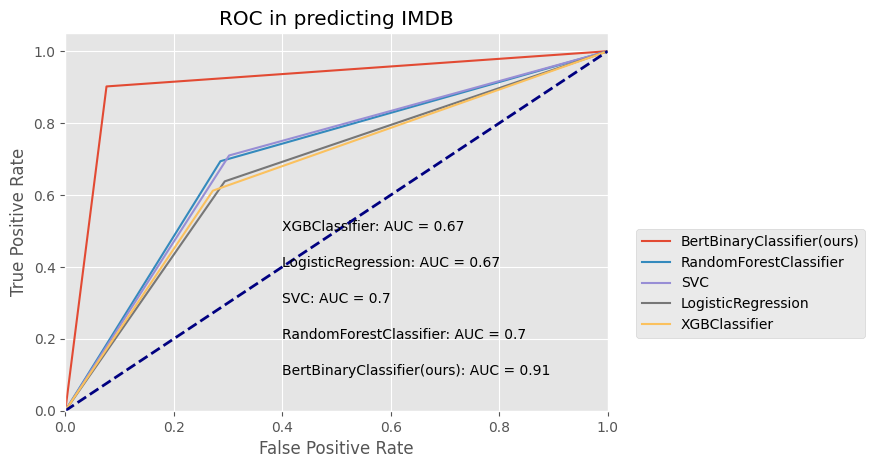

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
#SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#RF
from sklearn.ensemble import RandomForestClassifier
#LR
from sklearn.linear_model import LogisticRegression
#XGBoost
plt.style.use("ggplot")
import seaborn as sns
import xgboost as xgb
perf = {}

fpr, tpr, _ = roc_curve(BERT_test_y, bert_predicted)
auroc = roc_auc_score(BERT_test_y, bert_predicted)
perf["BertBinaryClassifier(ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

models = [BertBinaryClassifier(),RandomForestClassifier(),SVC(probability=True),LogisticRegression(),xgb.XGBClassifier()]
perf = {}
for model in models:
  if type(model).__name__ == "BertBinaryClassifier":
    fpr, tpr, _ = roc_curve(BERT_test_y, bert_predicted)
    auroc = roc_auc_score(BERT_test_y, bert_predicted)
    perf["BertBinaryClassifier(ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}
  else:
    fit = model.fit(X_train, Y_train)
    #y_test_prob = fit.predict_proba(X_test)[:,0]
    y_test_prob = fit.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, y_test_prob)
    auroc = roc_auc_score(Y_test, y_test_prob)
    perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

auroc

In [ ]:
from xgboost.sklearn import train
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
#SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
#RF
from sklearn.ensemble import RandomForestClassifier
#LR
from sklearn.linear_model import LogisticRegression
#XGBoost
plt.style.use("ggplot")
import seaborn as sns
import xgboost as xgb

split_rate = [0.2,0.4,0.6,0.8]
logreg_list = []
SVC_list = []
RandomForestClassifier_list=[]
xgb_list = []
bert_list = []

for i in split_rate:
  AUROC_X_train, AUROC_X_test, AUROC_y_train, AUROC_y_test = train_test_split(X_train, Y_train, train_size=i,test_size=1-i)
  AUROC_x_train_BERT,AUROC_x_test_BERT,AUROC_y_train_BERT,AUROC_y_test_BERT = train_test_split(x_train_BERT,BERT_train_y)
  #BERT
  #bert_fpr,bert_tpr,bert_thresholds = metrics.roc_curve(BERT_train_y,bert_predicted)
  #bert_list.append(metrics.auc(bert_fpr, bert_tpr))
  #----------------------------------------------
  #logistic regression
  logitreg = LogisticRegression()
  logitreg.fit(AUROC_X_train, AUROC_y_train)
  #y_test_prob = logitreg.predict_proba(X_test)[:,0]
  y_test_prob = logitreg.predict(X_test)


  fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_test_prob)
  # print(metrics.auc(fpr, tpr))
  #logreg_list.append(metrics.auc(fpr, tpr))
  #---------------------------------
  #SVC
  SVC_fit = SVC(probability=True).fit(AUROC_X_test,AUROC_y_test)
  #SVC_y_test_prob = SVC_fit.predict_proba(X_test)[:,0]
  SVC_y_test_prob = SVC_fit.predict(X_test)
  SVC_fpr, SVC_tpr, SVC_thresholds = metrics.roc_curve(Y_test, SVC_y_test_prob)
  #SVC_list.append(metrics.auc(SVC_fpr, SVC_tpr))
  #---------------------------------
  #RandomForestClassifier
  RFC_fit = RandomForestClassifier().fit(AUROC_X_test,AUROC_y_test)
  #RFC_y_test_prob = RFC_fit.predict_proba(X_test)[:,0]
  RFC_y_test_prob = RFC_fit.predict(X_test)
  RFC_fpr, RFC_tpr, RFC_thresholds = metrics.roc_curve(Y_test, RFC_y_test_prob)
  #RandomForestClassifier_list.append(metrics.auc(RFC_fpr, RFC_tpr))
  #---------------------------------
  #xgb
  xgb_fit = xgb.XGBClassifier().fit(AUROC_X_test,AUROC_y_test)
  #xgb_y_test_prob = xgb_fit.predict_proba(X_test)[:,0]
  xgb_y_test_prob = xgb_fit.predict(X_test)
  xgb_fpr, xgb_tpr, xgb_thresholds = metrics.roc_curve(Y_test, xgb_y_test_prob)
  #xgb_list.append(metrics.auc(xgb_fpr, xgb_tpr))

#when we use 100% data train
split_rate.append(1.0)
logitreg.fit(AUROC_X_train, AUROC_y_train)
y_test_prob = logitreg.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_test_prob)
logreg_list.append(metrics.auc(fpr, tpr))

SVC_fit = SVC(probability=True).fit(AUROC_X_test,AUROC_y_test)
#SVC_y_test_prob = SVC_fit.predict_proba(X_test)[:,0]
SVC_y_test_prob = SVC_fit.predict(X_test)
SVC_fpr, SVC_tpr, SVC_thresholds = metrics.roc_curve(Y_test, SVC_y_test_prob)
SVC_list.append(metrics.auc(SVC_fpr, SVC_tpr))

RFC_fit = RandomForestClassifier().fit(AUROC_X_test,AUROC_y_test)
#RFC_y_test_prob = RFC_fit.predict_proba(X_test)[:,0]
RFC_y_test_prob = RFC_fit.predict(X_test)
RFC_fpr, RFC_tpr, RFC_thresholds = metrics.roc_curve(Y_test, RFC_y_test_prob)
RandomForestClassifier_list.append(metrics.auc(RFC_fpr, RFC_tpr))

xgb_fit = xgb.XGBClassifier().fit(AUROC_X_test,AUROC_y_test)
#xgb_y_test_prob = xgb_fit.predict_proba(X_test)[:,0]
xgb_y_test_prob = xgb_fit.predict(X_test)
xgb_fpr, xgb_tpr, xgb_thresholds = metrics.roc_curve(Y_test, xgb_y_test_prob)
xgb_list.append(metrics.auc(xgb_fpr, xgb_tpr))

bert_fpr,bert_tpr,bert_thresholds = metrics.roc_curve(BERT_test_y,bert_predicted)
bert_list.append(metrics.auc(bert_fpr, bert_tpr))

all_list = [bert_list[0],logreg_list[0],SVC_list[0],RandomForestClassifier_list[0],xgb_list[0]]

(5, 6)


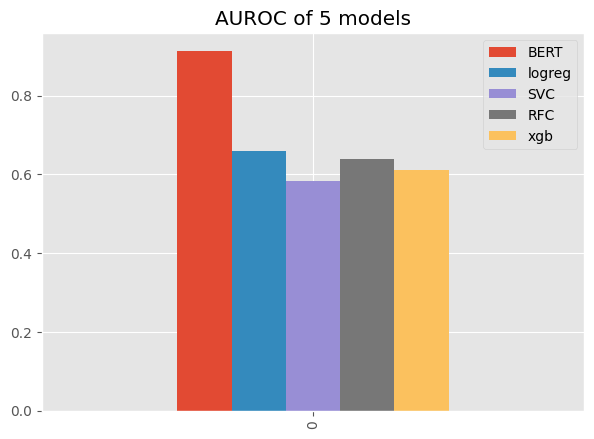

,BERT,logreg,SVC,RFC,xgb
0,0.913,0.658,0.583,0.638,0.612


In [ ]:
X_axis = ["BERT","logreg","SVC","RFC","xgb"]
AUROC_DF = pd.DataFrame({'BERT':bert_list[0],'logreg':logreg_list[0],'SVC':SVC_list[0],'RFC':RandomForestClassifier_list[0],'xgb':xgb_list[0], "X":X_axis})
print(AUROC_DF.shape)
AUROC_DF = AUROC_DF.drop([1,2,3,4])
AUROC_DF = AUROC_DF.drop(columns=['X'])
# AUROC_DF.index = X_axis
# print(AUROC_DF.index)
# print(AUROC_DF.loc[:,"logreg"])
# print(AUROC_DF.loc[:,"SVC"])
# print(AUROC_DF.loc[:,"RFC"])
# print(AUROC_DF.loc[:,"xgb"])
AUROC_DF.plot.bar()
plt.title('AUROC of 5 models')
plt.show()
AUROC_DF

In [ ]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train,Y_train)


rf.feature_importances_

feature_df = pd.DataFrame(open(home_dir + "aclImdb/imdb.vocab","r"))

sorted_idx = rf.feature_importances_.argsort()
feature_top20_X = rf.feature_importances_[sorted_idx]
sort_index_top20 = sorted_idx[np.r_[0:20]]
feature_top20_Y = feature_df.iloc[sort_index_top20]
feature_top20_X = feature_top20_X[0:20]
plt.barh(list(feature_top20_Y[0]), feature_top20_X)

plt.title('Random Forest top20 importance features')
plt.ylabel('features')
plt.xlabel('importance')

# GPT

In [ ]:
# Install transformers library.
os.system("pip install git+https://github.com/huggingface/transformers")
# Install helper functions.
os.system("pip install git+https://github.com/gmihaila/ml_things")

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


## helper function

In [ ]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in ['pos', 'neg']:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


## validation(dataloader, device_)

In [ ]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in ['pos', 'neg']:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss


## Load Model and Tokenizer

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## Dataset and Collator

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


Dealing with Train...


ValueError: ignored

## Train

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
